# Customer Segmentation with Clustering 🛍️

**Project Objective:** To use unsupervised machine learning to identify distinct groups of customers within a mall's dataset. By segmenting customers based on multiple dimensions (income, age, spending habits), we can provide rich, actionable insights to the marketing team for highly targeted campaigns.

### Step 1: Setup - Importing Libraries and Loading Data

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set plot style
sns.set_style('whitegrid')

In [36]:
# Load the dataset from the user-provided file
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/Mall_Customers.csv')

print("Dataset loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.
Dataset loaded successfully.
Data shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Step 2: In-Depth Exploratory Data Analysis (EDA)


In [37]:
# Basic info and statistics
print("Dataset Info:")
df.info()

# Drop the CustomerID as it's just an identifier and not useful for clustering
df.drop('CustomerID', axis=1, inplace=True)

print("\nDescriptive Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Descriptive Statistics:
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     4

#### 2.1 Univariate Analysis (Feature Distributions)

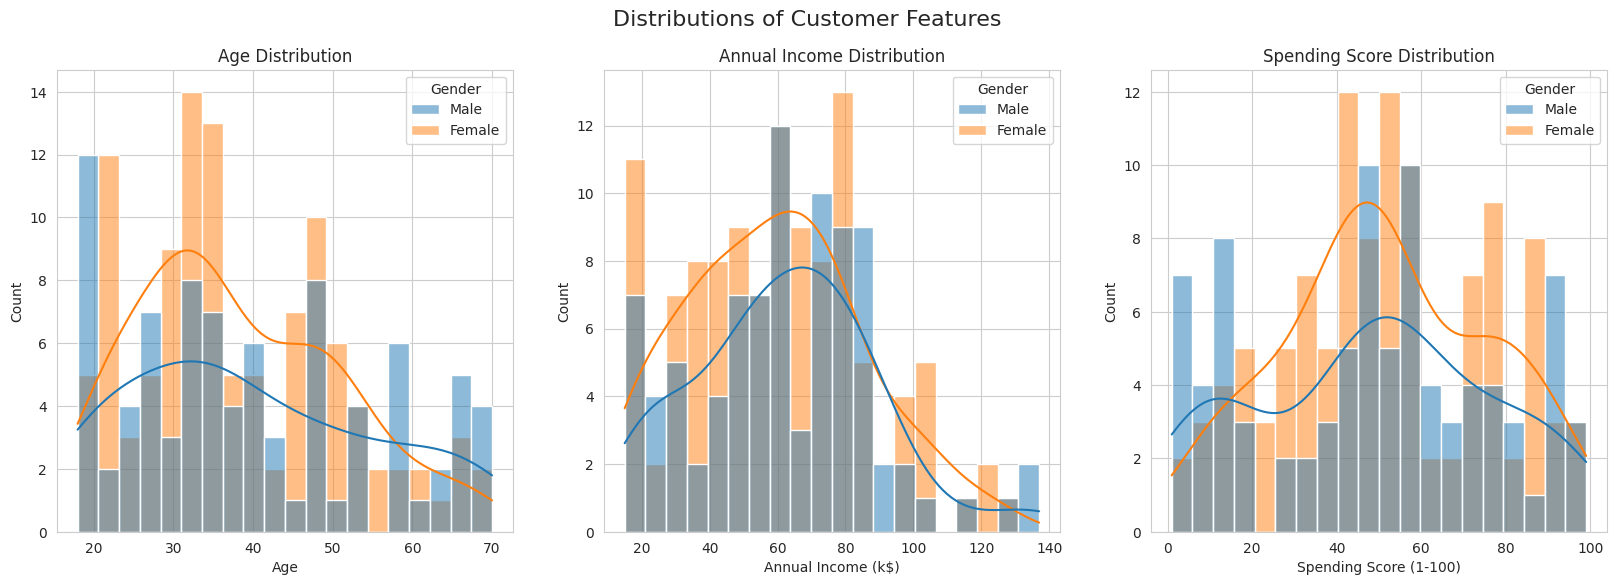

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Customer Features', fontsize=16)

sns.histplot(ax=axes[0], data=df, x='Age', kde=True, bins=20, hue='Gender').set_title('Age Distribution')
sns.histplot(ax=axes[1], data=df, x='Annual Income (k$)', kde=True, bins=20, hue='Gender').set_title('Annual Income Distribution')
sns.histplot(ax=axes[2], data=df, x='Spending Score (1-100)', kde=True, bins=20, hue='Gender').set_title('Spending Score Distribution')

plt.show()

#### 2.2 Bivariate Analysis (Looking for Relationships)

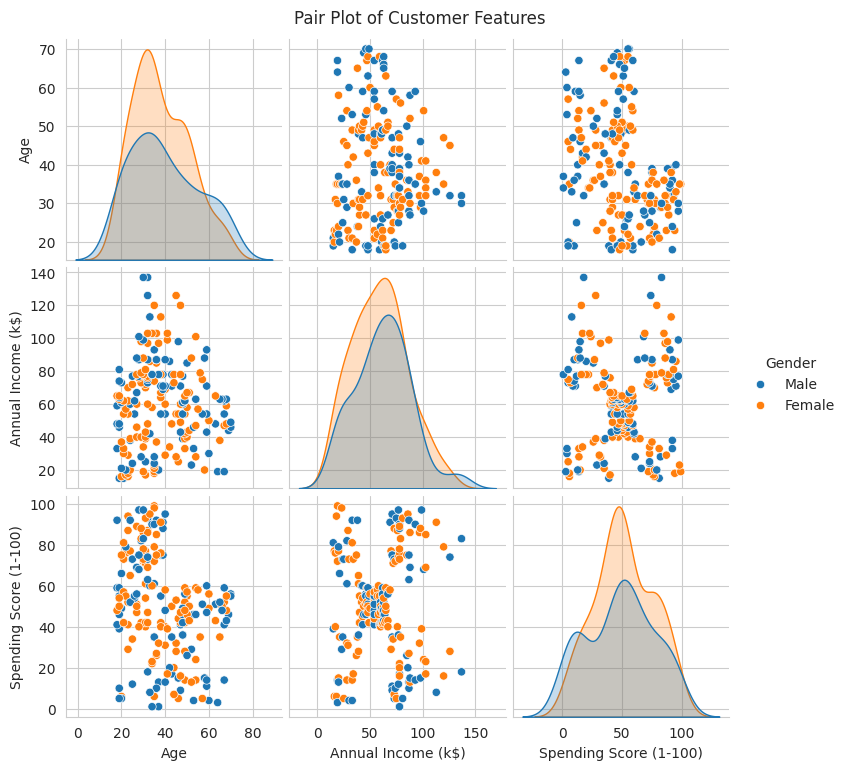

In [39]:
# Using pairplot to visualize relationships between all numerical variables
sns.pairplot(df, vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], hue='Gender', diag_kind='kde')
plt.suptitle('Pair Plot of Customer Features', y=1.02)
plt.show()

#### 2.3 3D Visualization

In [40]:
fig = px.scatter_3d(df,
                    x='Annual Income (k$)',
                    y='Spending Score (1-100)',
                    z='Age',
                    color='Gender',
                    title='3D View of Customer Data')
fig.show()

### Step 3: Segmentation Model 1 - Income & Spending Score

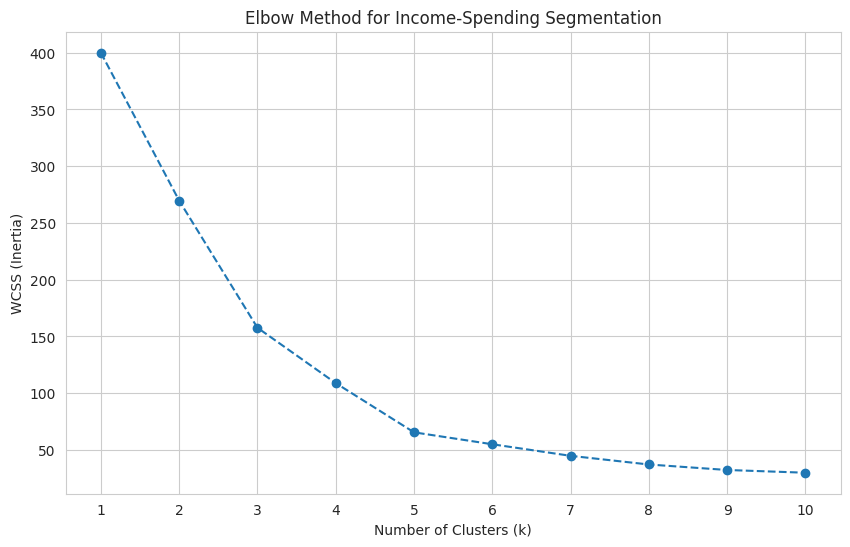

In [41]:
# 1. Select and scale the features
X1 = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

# 2. Implement the Elbow Method
wcss1 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X1_scaled)
    wcss1.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
plt.title('Elbow Method for Income-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

**Observation:** The "elbow" of the curve is clearly at **k=5**. The WCSS decreases sharply until k=5, and then the rate of decrease flattens out. This confirms our visual intuition from the scatter plot!

In [42]:
# Build and fit the final model
kmeans1 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
df['Income_Cluster'] = kmeans1.fit_predict(X1_scaled)

#### 3.1 Visualizing and Interpreting the Income-Based Segments

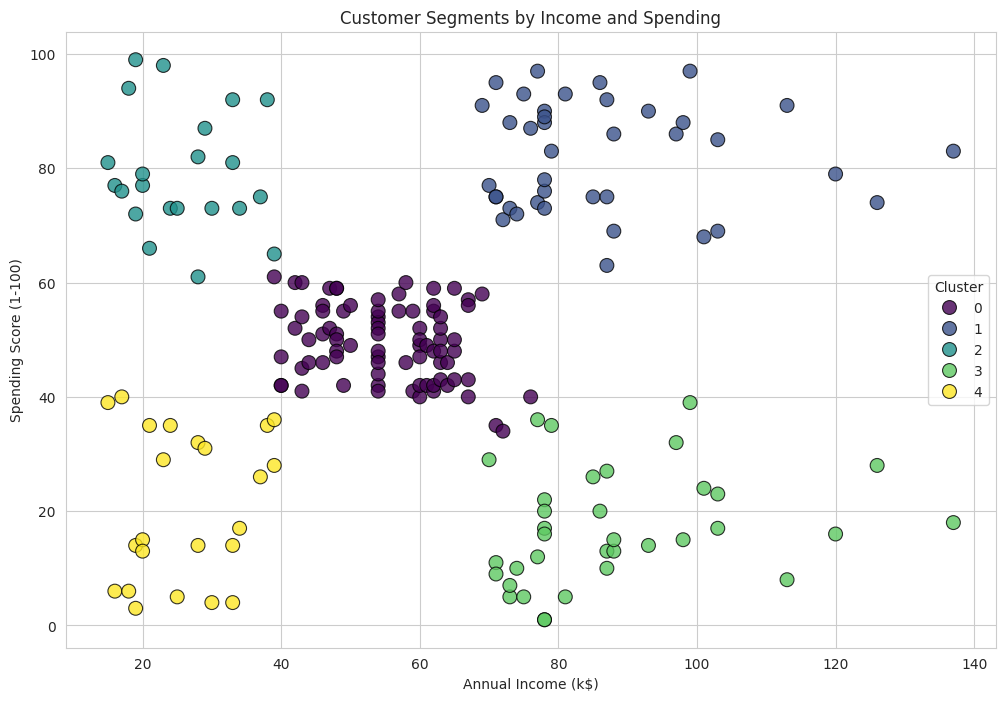

In [43]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Income_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Income and Spending')
plt.legend(title='Cluster')
plt.show()

In [44]:
# Quantitative Persona Analysis
cluster_profiles1 = df.groupby('Income_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
cluster_profiles1['Size'] = df['Income_Cluster'].value_counts()
print("--- Income-Based Cluster Profiles ---")
cluster_profiles1

--- Income-Based Cluster Profiles ---


,Age,Annual Income (k$),Spending Score (1-100),Size
Income_Cluster,,,,
0,42.72,55.30,49.52,81
1,32.69,86.54,82.13,39
2,25.27,25.73,79.36,22
3,41.11,88.20,17.11,35
4,45.22,26.30,20.91,23


#### 3.2 Income-Based Personas and Strategy
Using the quantitative profiles, we can define our segments:
- **Cluster 0 (Careful High-Earners):** High income (~88k) but low spending (~17). Cautious, value-driven buyers.
- **Cluster 1 (Standard):** Average income (~55k) and spending (~50). This is the largest, core customer group.
- **Cluster 2 (Budget Shoppers):** Low income (~26k) and low spending (~21). Highly price-sensitive.
- **Cluster 3 (Target - High Value):** High income (~87k) and high spending (~82). The mall's prime target.
- **Cluster 4 (Enthusiasts):** Low income (~26k) but high spending (~79). Likely young, trend-focused shoppers.

### Step 4: Segmentation Model 2 - Age & Spending Score

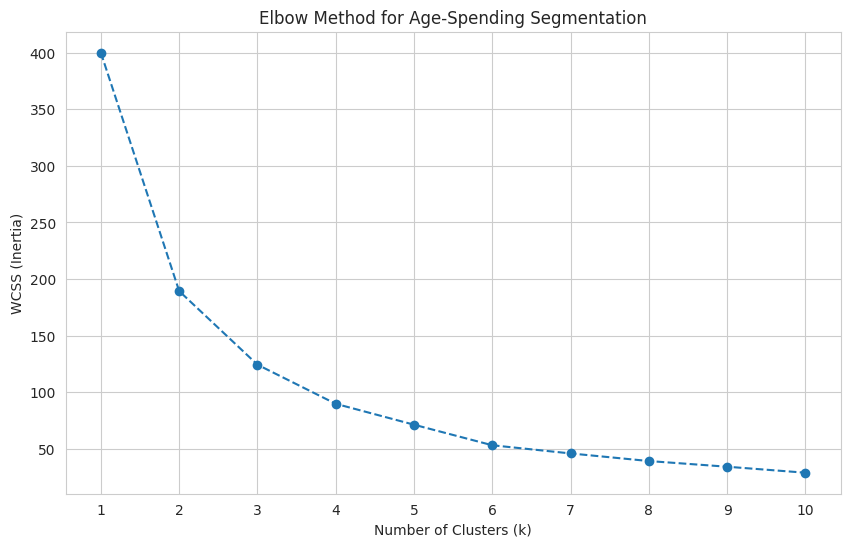

In [45]:
# 1. Select and scale the features
X2 = df[['Age', 'Spending Score (1-100)']]
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# 2. Implement the Elbow Method
wcss2 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X2_scaled)
    wcss2.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss2, marker='o', linestyle='--')
plt.title('Elbow Method for Age-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

**Observation:** The elbow is less sharp here, but **k=4** appears to be a reasonable choice.

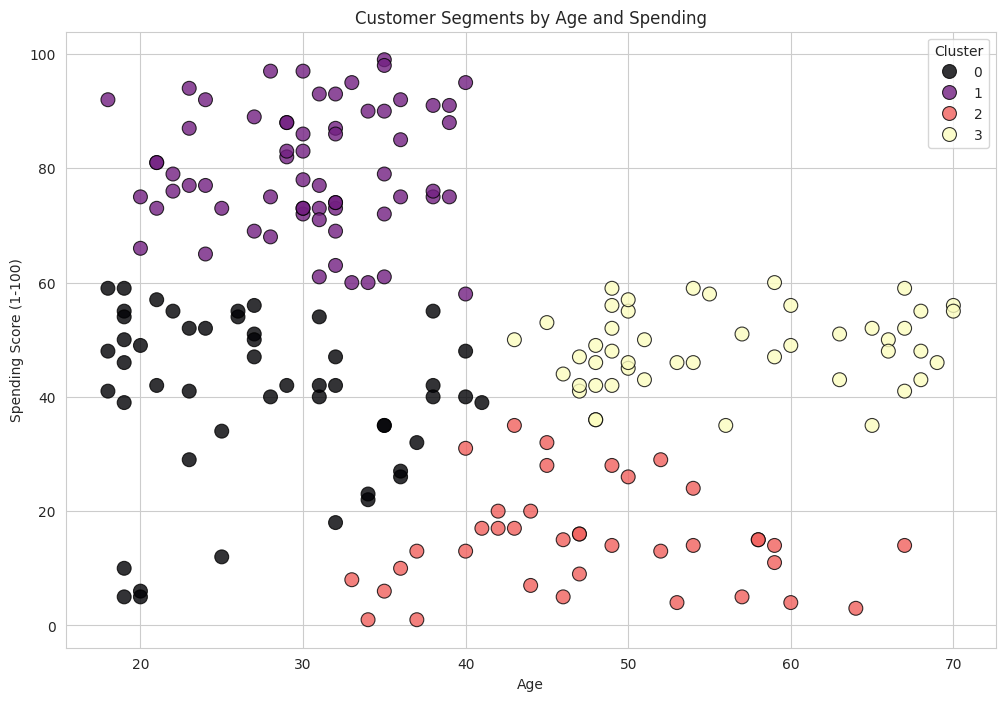

In [46]:
# Build and fit the final model for age segmentation
kmeans2 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Age_Cluster'] = kmeans2.fit_predict(X2_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)',
                hue='Age_Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Age and Spending')
plt.legend(title='Cluster')
plt.show()

#### 4.1 Interpreting the Age-Based Segments
This model gives us a different perspective:
- **Young High-Spenders:** A clear group of customers under 40 with high spending scores.
- **Young Low-Spenders:** Customers under 40 with low-to-moderate spending.
- **Older Average-Spenders:** Customers over 40 with moderate spending scores.
- **Older Low-Spenders:** A small group of older customers with very low spending scores.

### Step 5: An Alternative Method - Hierarchical Clustering
(Another Clistering Technique)

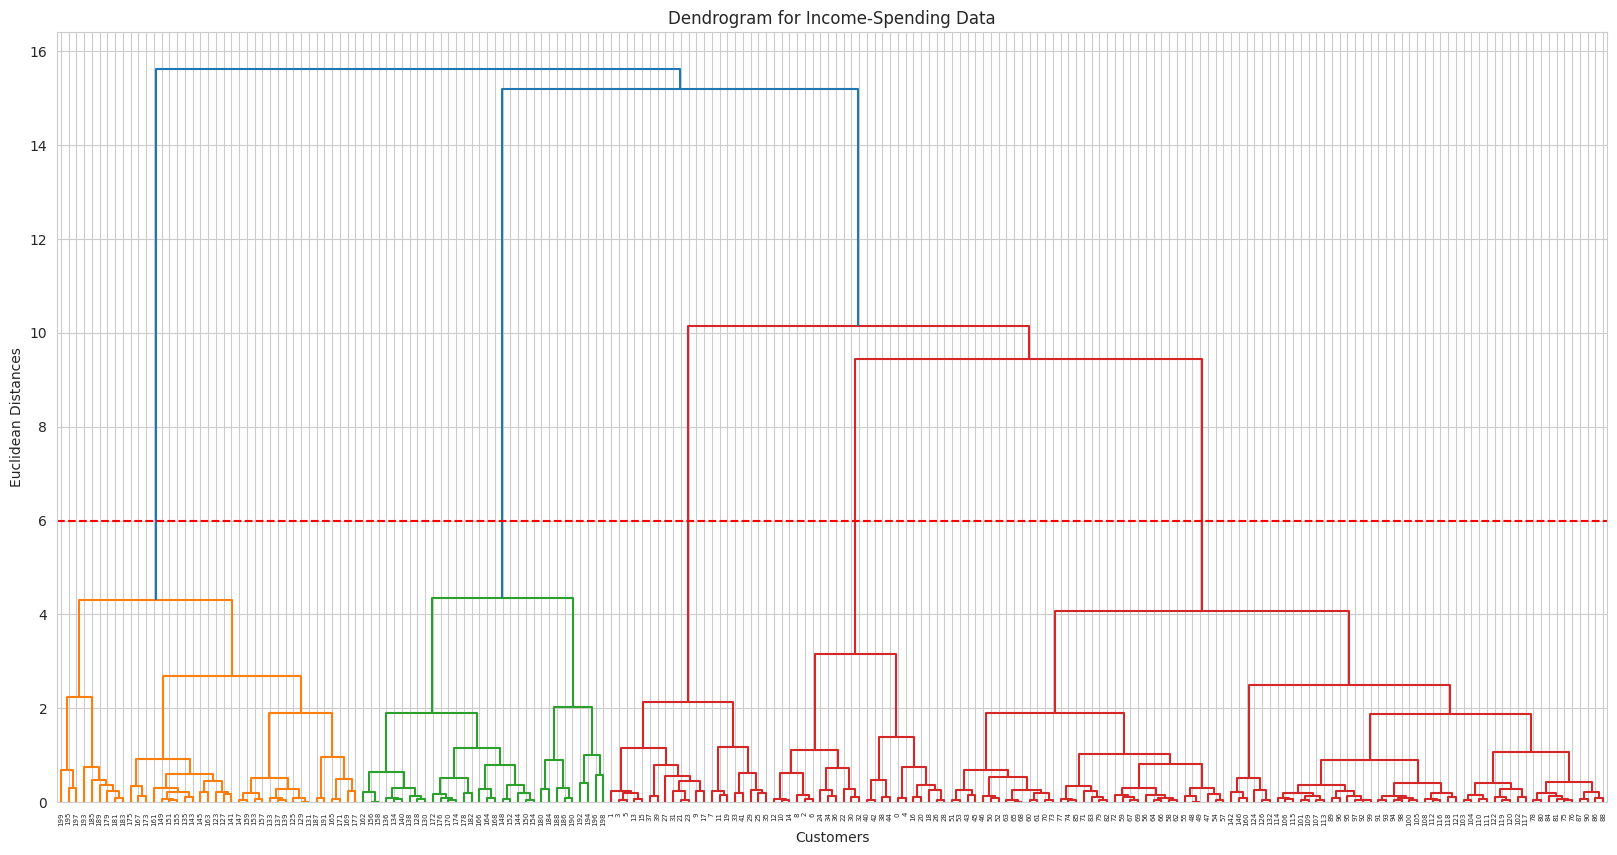

In [47]:
plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(sch.linkage(X1_scaled, method='ward'))
plt.title('Dendrogram for Income-Spending Data')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=6, color='r', linestyle='--') # Example cut-off line
plt.show()

**Insight:** The dendrogram also confirms that **5 clusters** is the optimal number for the income-spending data. If we draw a horizontal line at a height of 6 (as shown by the red dashed line), it crosses five vertical lines.

### Step 6: Segmentation Model 3 - Gender & Spending Score

/tmp/ipython-input-4076818802.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




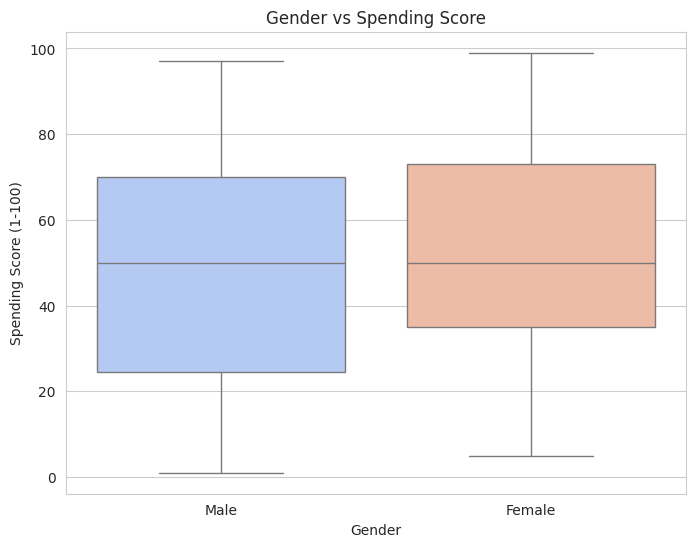

In [48]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Gender', y='Spending Score (1-100)', palette='coolwarm')
plt.title('Gender vs Spending Score')
plt.show()

In [49]:
print("\nAverage Spending Score by Gender:")
print(df.groupby('Gender')['Spending Score (1-100)'].describe().round(2))


Average Spending Score by Gender:
        count   mean    std  min   25%   50%   75%   max
Gender                                                  
Female  112.0  51.53  24.11  5.0  35.0  50.0  73.0  99.0
Male     88.0  48.51  27.90  1.0  24.5  50.0  70.0  97.0


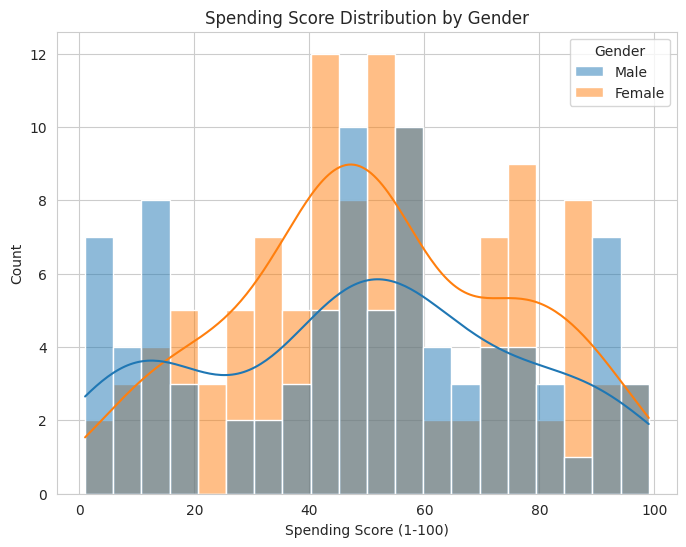

In [50]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Spending Score (1-100)', hue='Gender', kde=True, bins=20)
plt.title('Spending Score Distribution by Gender')
plt.show()

In [51]:
from sklearn.preprocessing import LabelEncoder

# Encode Gender for clustering
encoder = LabelEncoder()
df['Gender_Num'] = encoder.fit_transform(df['Gender'])  # Male=1, Female=0 (typically)

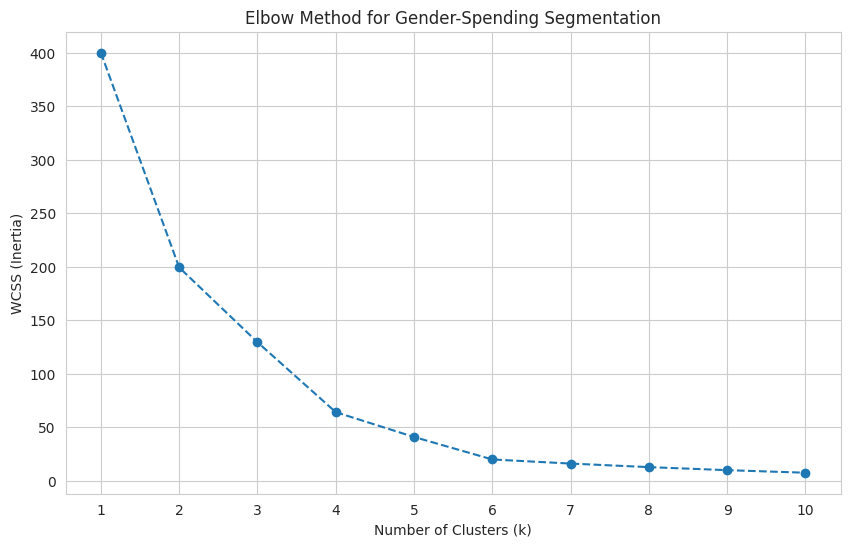

In [52]:
# Prepare data for gender-based clustering
X_gender = df[['Gender_Num', 'Spending Score (1-100)']]
scaler_g = StandardScaler()
X_gender_scaled = scaler_g.fit_transform(X_gender)

# Elbow Method
wcss_g = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_gender_scaled)
    wcss_g.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss_g, marker='o', linestyle='--')
plt.title('Elbow Method for Gender-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

In [53]:
# Apply KMeans
kmeans_g = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
df['Gender_Cluster'] = kmeans_g.fit_predict(X_gender_scaled)

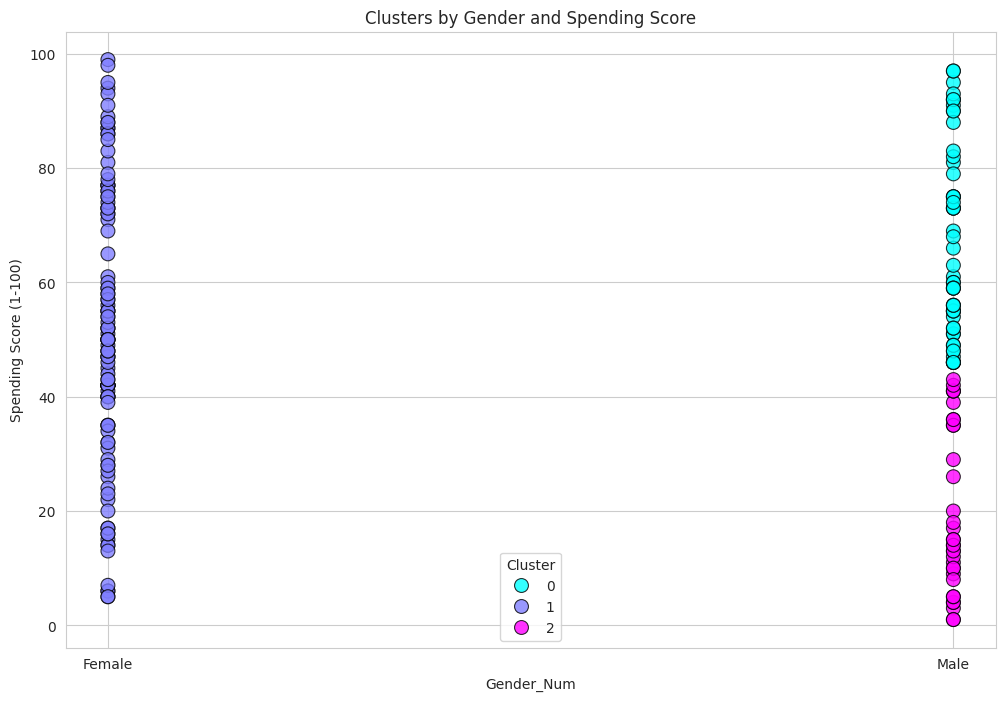

In [54]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Gender_Num', y='Spending Score (1-100)',
                hue='Gender_Cluster', palette='cool', s=100, alpha=0.8, edgecolor='black')
plt.title('Clusters by Gender and Spending Score')
plt.xticks([0, 1], ['Female', 'Male'])
plt.legend(title='Cluster')
plt.show()

**Insight (Gender vs Spending Score Clusters):**

The scatter plot shows customer clusters based on **Gender** and **Spending Score**:

- **Female-dominated cluster(s):** Groups of mostly female customers with similar spending behavior  
- **Male-dominated cluster(s):** Groups of mostly male customers with similar spending behavior  
- **Mixed-spending patterns:** Some clusters may include both genders but highlight differences in average spending.

In [55]:
cluster_profiles_g = df.groupby('Gender_Cluster')[['Gender_Num', 'Spending Score (1-100)']].mean().round(2)
cluster_profiles_g['Size'] = df['Gender_Cluster'].value_counts()
print("--- Gender-Based Cluster Profiles ---")
print(cluster_profiles_g)

--- Gender-Based Cluster Profiles ---
                Gender_Num  Spending Score (1-100)  Size
Gender_Cluster                                          
0                      1.0                   66.72    54
1                      0.0                   51.53   112
2                      1.0                   19.59    34


### Step 7: Feature Engineering

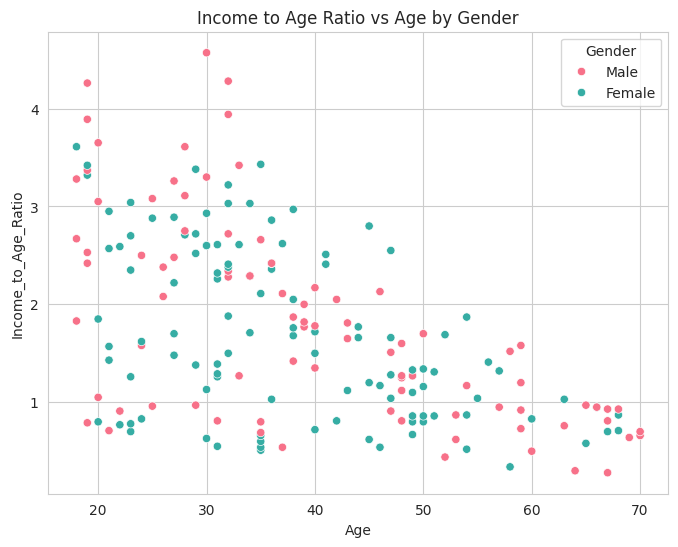

In [56]:
# Create new feature: Income to Age Ratio
df['Income_to_Age_Ratio'] = (df['Annual Income (k$)'] / df['Age']).round(2)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Age', y='Income_to_Age_Ratio', hue='Gender', palette='husl')
plt.title('Income to Age Ratio vs Age by Gender')
plt.show()

In [57]:
# Prepare for clustering
X3 = df[['Income_to_Age_Ratio', 'Spending Score (1-100)']]
scaler3 = StandardScaler()
X3_scaled = scaler3.fit_transform(X3)

In [58]:
# Elbow Method
wcss3 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X3_scaled)
    wcss3.append(kmeans.inertia_)

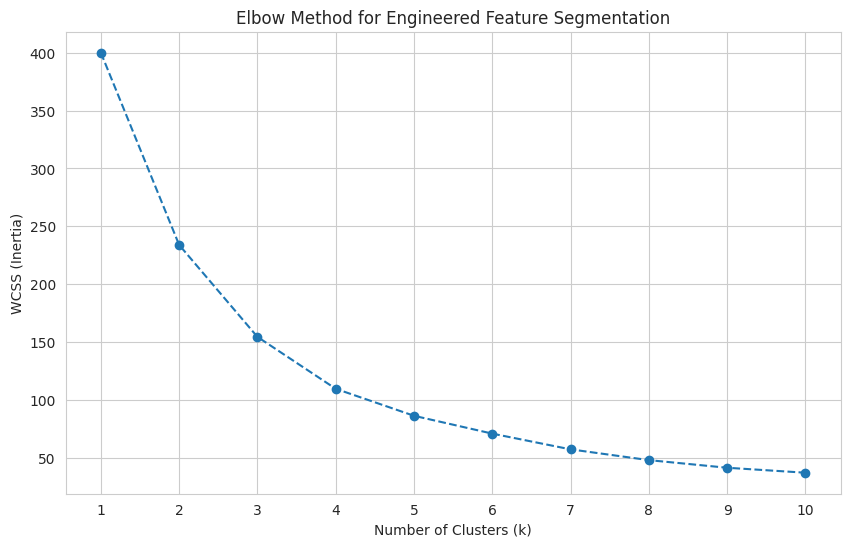

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss3, marker='o', linestyle='--')
plt.title('Elbow Method for Engineered Feature Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

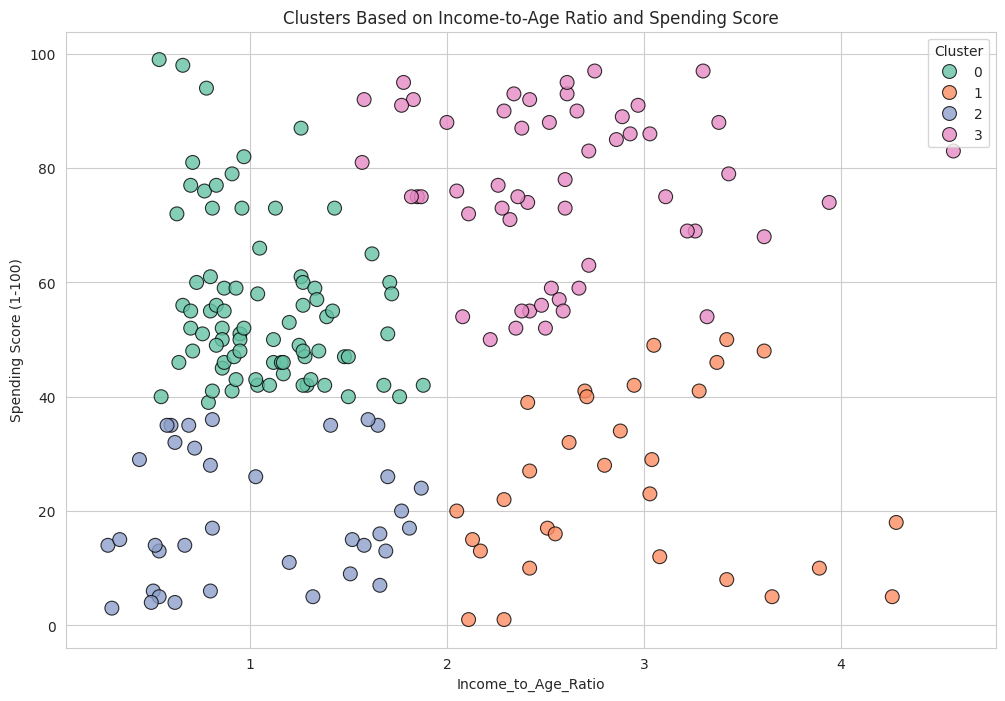

In [60]:
# Apply KMeans
kmeans3 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Engineered_Cluster'] = kmeans3.fit_predict(X3_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Income_to_Age_Ratio', y='Spending Score (1-100)',
                hue='Engineered_Cluster', palette='Set2', s=100, alpha=0.8, edgecolor='black')
plt.title('Clusters Based on Income-to-Age Ratio and Spending Score')
plt.legend(title='Cluster')
plt.show()

**Insight:**

The plot shows distinct customer clusters based on **Income-to-Age Ratio** and **Spending Score**, identifying:

- **High-value customers:** High income efficiency & high spending  
- **Budget-conscious customers:** Low income efficiency & low spending  
- **Moderate-income high-spenders:** Moderate income but high spending.


In [61]:
cluster_profiles3 = df.groupby('Engineered_Cluster')[['Income_to_Age_Ratio', 'Spending Score (1-100)', 'Age', 'Annual Income (k$)']].mean().round(2)
cluster_profiles3['Size'] = df['Engineered_Cluster'].value_counts()
print("--- Engineered Feature-Based Cluster Profiles ---")
print(cluster_profiles3)

--- Engineered Feature-Based Cluster Profiles ---
                    Income_to_Age_Ratio  Spending Score (1-100)    Age  \
Engineered_Cluster                                                       
0                                  1.07                   55.85  44.03   
1                                  2.91                   24.73  30.40   
2                                  1.02                   19.03  48.64   
3                                  2.58                   76.38  29.62   

                    Annual Income (k$)  Size  
Engineered_Cluster                            
0                                45.65    79  
1                                84.60    30  
2                                49.42    36  
3                                76.16    55  
